In this notebook, we will work through a simulation of psychophysiological interaction

In [1]:
import os,sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../')
from utils.mkdesign import create_design_singlecondition
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from utils.make_data import make_continuous_data
from statsmodels.tsa.arima_process import arma_generate_sample
import scipy.stats
import seaborn as sns
sns.set_style("white")

results_dir = os.path.abspath("../results")
if not os.path.exists(results_dir):
    os.mkdir(results_dir)


Load the data generated using the DCM forward model. In this model, there should be a significant PPI between roi 0 and rois 2 and 4 (see the B matrix in the DCM notebook)

In [2]:
dcmdata=numpy.load(os.path.join(results_dir,'dcmdata.npz'))
data_conv=dcmdata['data']
# downsample to 1 second TR
data=data_conv[range(0,data_conv.shape[0],100)]
ntp=data.shape[0]

# create a blocked design
d,design=create_design_singlecondition(blockiness=1.0,deslength=ntp,blocklength=20,offset=20)

regressor,_=compute_regressor(design,'spm',numpy.arange(0,ntp))

../utils/mkdesign.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  design[b:b+blocklength]=1


(-50, 300)

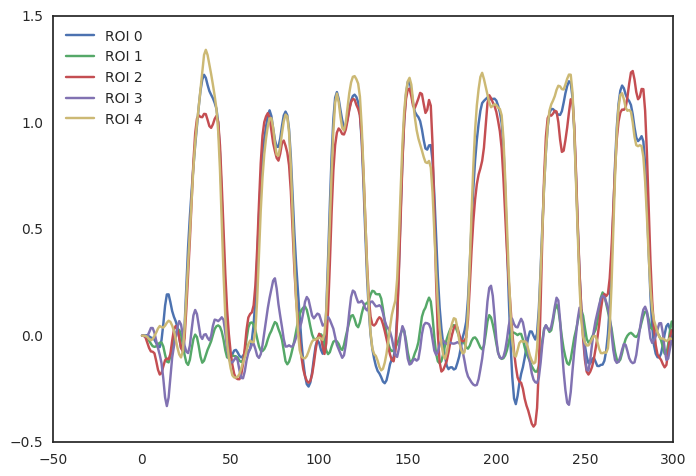

In [3]:
for i in range(data.shape[1]):
    plt.plot(data[:,i], label="ROI %d"%i)
plt.legend(loc="best")
plt.xlim([-50,300])

Set up the PPI model, using ROI 0 as the seed

ROI 0: 3.86593321294 6.80322958119e-05
ROI 1: 1.01708139751 0.154972654455
ROI 2: 1.42428415275 0.077708801814
ROI 3: 1.80274877169 0.0362223520829
ROI 4: 9.01167903117 0.0


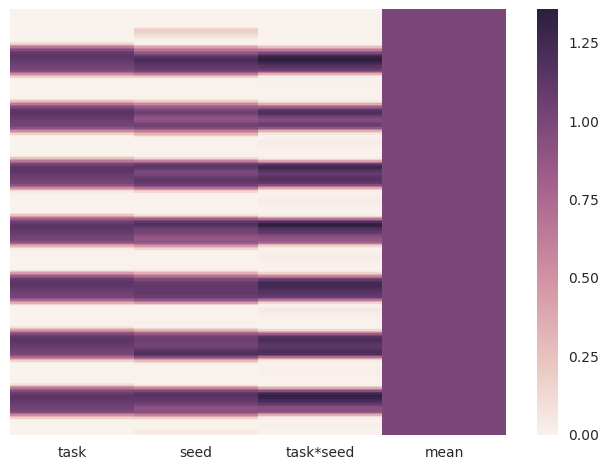

In [5]:
seed=0
X=numpy.vstack((regressor[:,0],data[:,seed],regressor[:,0]*data[:,seed],numpy.ones(data.shape[0]))).T
hat_mtx=numpy.linalg.inv(X.T.dot(X)).dot(X.T)

for i in range(data.shape[1]):
    beta_hat=hat_mtx.dot(data[:,i])
    resid=data[:,i] - X.dot(beta_hat)
    sigma2hat=(resid.dot(resid))/(X.shape[0] - X.shape[1])
    c=numpy.array([0,0,1,0])  # contrast for PPI
    t=c.dot(beta_hat)/numpy.sqrt(c.dot(numpy.linalg.inv(X.T.dot(X)).dot(c))*sigma2hat)
    print ('ROI %d:'%i, t, 1.0 - scipy.stats.t.cdf(t,X.shape[0] - X.shape[1]))
    
import seaborn as sns
sns.heatmap(X, vmin=0, xticklabels=["task", "seed", "task*seed", "mean"], 
            yticklabels=False)

Let's plot the relation between the ROIs as a function of the task

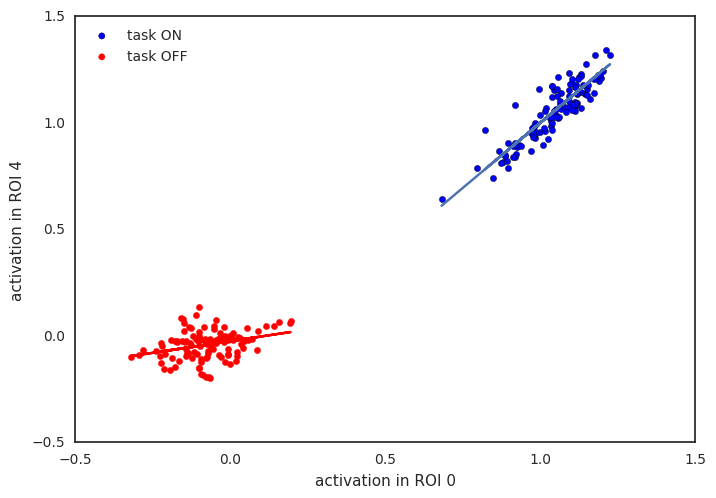

In [6]:
on_tp=numpy.where(regressor>0.9)[0]
off_tp=numpy.where(regressor<0.01)[0]
roinum=4

plt.scatter(data[on_tp,0],data[on_tp,roinum], label="task ON")
fit = numpy.polyfit(data[on_tp,0],data[on_tp,roinum],1)
plt.plot(data[on_tp,0],data[on_tp,0]*fit[0] +fit[1])
plt.scatter(data[off_tp,0],data[off_tp,roinum],color='red', label="task OFF")
fit = numpy.polyfit(data[off_tp,0],data[off_tp,roinum],1)
plt.plot(data[off_tp,0],data[off_tp,0]*fit[0] +fit[1],color='red')
plt.xlabel("activation in ROI 0")
plt.ylabel("activation in ROI %d"%roinum)
plt.legend(loc="best")
